In [6]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
font_location = 'C:/Windows/Fonts/malgunbd.ttf' # matplotlib 한글 맑은 고딕 폰트 설정
font_name = fm.FontProperties(fname=font_location).get_name()
matplotlib.rc('font', family=font_name)
import pickle
import operator

from konlpy.tag import Okt
from konlpy.tag import Mecab

from nltk import bigrams, word_tokenize
from nltk.util import ngrams
from nltk.tokenize import sent_tokenize
from collections import Counter
from tqdm import tqdm
from sklearn.utils import shuffle
from wordcloud import WordCloud


import re
import kss

okt = Okt()
mecab = Mecab()

ModuleNotFoundError: No module named 'kss'

In [7]:
df = pd.read_csv('맛집리뷰.csv')

In [231]:
def make_df(df): # 첫 리뷰가 컬럼에 들어가는 문제 해결
    first = np.array(df.columns).reshape(1,-1)
    df.columns = ['리뷰', '평점', '답변', '예약이름', '가게이름'] #컬럼 
    first_df = pd.DataFrame(first, columns = list(df.columns))
    df = df.append(first_df)
    return df

df = make_df(df)
df = df.drop_duplicates()

# 리뷰 전처리
- 참고 : https://colab.research.google.com/drive/1FfhWsP9izQcuVl06P30r5cCxELA1ciVE?usp=sharing#scrollTo=d7Lth3pazP88

In [194]:
#전처리용 함수 설정
punct = "/-'?!.,#$%\'()*+-/:;<=>@[\\]^_`{|}~" + '""“”’' + '∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&'
punct_mapping = {"‘": "'", "₹": "e", "´": "'", "°": "", "€": "e", "™": "tm", "√": " sqrt ", "×": "x", "²": "2", "—": "-", "–": "-", "’": "'", "_": "-", "`": "'", '“': '"', '”': '"', '“': '"', "£": "e", '∞': 'infinity', 'θ': 'theta', '÷': '/', 'α': 'alpha', '•': '.', 'à': 'a', '−': '-', 'β': 'beta', '∅': '', '³': '3', 'π': 'pi', }

def clean_punc(text, punct, mapping):
    for p in mapping:
        text = text.replace(p, mapping[p])
    
    for p in punct:
        text = text.replace(p, f' {p} ')
    
    specials = {'\u200b': ' ', '…': ' ... ', '\ufeff': '', 'करना': '', 'है': ''}
    for s in specials:
        text = text.replace(s, specials[s])
    
    return text.strip()

def clean_text(reviews):
    corpus = []
    for review in reviews:
        temp_review = []
        for sentence in review:
            rev = re.sub(r'[@%\\*=()/~#&\+á?\xc3\xa1\-\|\.\:\;\!\-\,\_\~\$\'\"]', '',sentence) #기호 제거
            rev = re.sub(r'\d+','', rev)# 숫자 제거
            rev = re.sub(r'\s+', ' ', rev) #공백 제거
            rev = re.sub(r'<[^>]+>','',rev) #Html태그 제거
            rev = re.sub(r'\s+', ' ', rev) #공백 제거
            rev = re.sub(r"^\s+", '', rev) #첫 공백 제거
            rev = re.sub(r'\s+$', '', rev) #마지막 공백 제거
        corpus.append(review)
    return corpus

In [195]:
review_tokened = []

for review in df['리뷰']:
    review_token = []
    review = review.strip()
    for sentence in kss.split_sentences(review):
        sentence = re.sub('([a-zA-Z])','',sentence)
        sentence = re.sub('[ㄱ-ㅎㅏ-ㅣ]+','',sentence)
        sentence = re.sub('[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…;》\n]','',sentence)
        review_token.append(sentence)
    review_tokened.append(review_token)
    
cleaned_corpus = []
for review in review_tokened:
    temp_corpus = [] 
    for sentence in review:
        temp_corpus.append(clean_punc(sentence, punct, punct_mapping))
    cleaned_corpus.append(temp_corpus)
    
basic_preprocessed_corpus = clean_text(cleaned_corpus)

In [196]:
len(basic_preprocessed_corpus)

549123

In [580]:
df['리뷰전처리'] = basic_preprocessed_corpus

df['리뷰전처리'] = df['리뷰전처리'].apply(lambda x: (' ').join(x))

## 점수 분포도 확인

In [199]:
df['평점'] = df['평점'].astype(float) #점수 type 변환

(array([   823.,   7528.,    511.,   7479.,   1235.,  28172.,   3595.,
        113638.,  14357., 371785.]),
 array([0.5 , 0.95, 1.4 , 1.85, 2.3 , 2.75, 3.2 , 3.65, 4.1 , 4.55, 5.  ]),
 <a list of 10 Patch objects>)

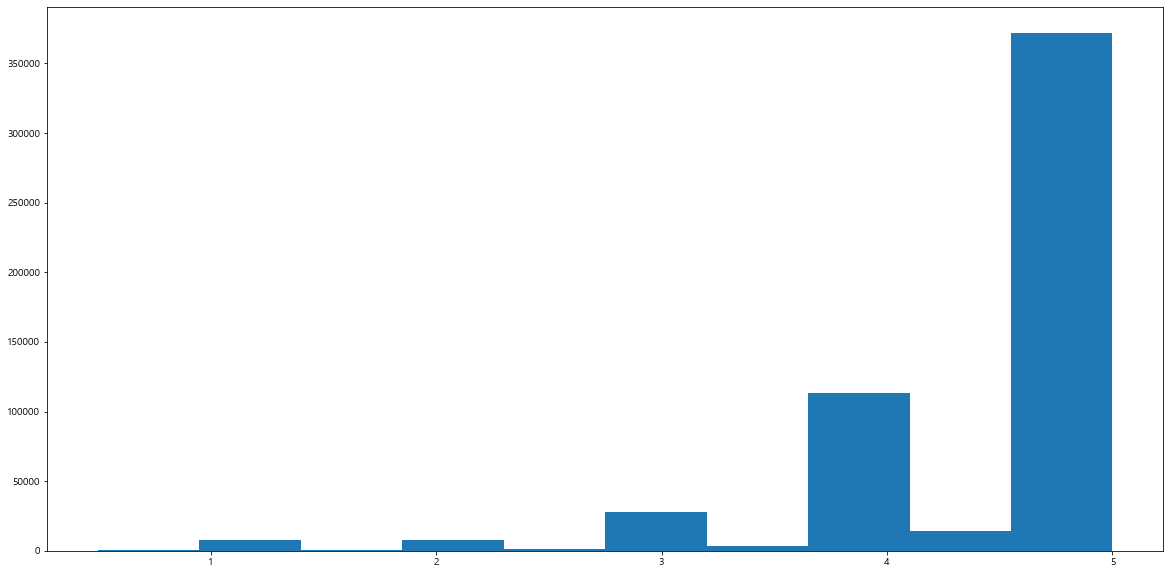

In [201]:
plt.figure(figsize=(20,10))
plt.hist(df['평점'])

- 단순히 중간인 2.5점을 기준으로 긍정 부정을 판가름하기 어렵다
    - 대부분의 평점이 4-5점 사이에 존재
    - 3.5점인 리뷰 확인

In [202]:
score3_df = df[df['평점'] == 3.5]

In [203]:
# 나누어진 문장들 뭉치기
score3_df['리뷰전처리'] = score3_df['리뷰전처리'].apply(lambda x: (' ').join(x))

C:\Users\sb\anaconda3\envs\nlp\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [217]:
review_3_modi = []
for review in score3_df['리뷰전처리']:
    temp = okt.morphs(review, stem=True) #어간 추출
    review_3_modi.append(temp)

In [219]:
from nltk import FreqDist

vocab = FreqDist(np.hstack(review_3_modi))
vocab = vocab.most_common(1000)
vocab

[('이', 2253),
 ('하다', 2020),
 ('좋다', 1675),
 ('맛있다', 1421),
 ('가', 1355),
 ('은', 1304),
 ('도', 1193),
 ('에', 1069),
 ('는', 1018),
 ('맛', 1007),
 ('먹다', 977),
 ('음식', 890),
 ('있다', 698),
 ('너무', 649),
 ('좀', 573),
 ('같다', 541),
 ('분위기', 536),
 ('않다', 500),
 ('아쉽다', 478),
 ('을', 452),
 ('친절하다', 445),
 ('이다', 429),
 ('으로', 419),
 ('서비스', 392),
 ('들', 384),
 ('보다', 378),
 ('괜찮다', 368),
 ('없다', 368),
 ('를', 362),
 ('직원', 353),
 ('가다', 347),
 ('예약', 325),
 ('조금', 323),
 ('나오다', 318),
 ('로', 307),
 ('많다', 303),
 ('적', 301),
 ('가격', 300),
 ('요', 297),
 ('다', 286),
 ('안', 285),
 ('것', 278),
 ('메뉴', 274),
 ('의', 270),
 ('자다', 257),
 ('한', 250),
 ('더', 247),
 ('고기', 234),
 ('그렇다', 230),
 ('되다', 229),
 ('분', 225),
 ('에서', 218),
 ('양', 218),
 ('주문', 217),
 ('방문', 215),
 ('많이', 209),
 ('고', 206),
 ('파스타', 202),
 ('오다', 197),
 ('생각', 196),
 ('때', 195),
 ('분들', 192),
 ('하고', 187),
 ('식사', 182),
 ('아니다', 179),
 ('자리', 178),
 ('과', 175),
 ('느낌', 168),
 ('다른', 168),
 ('다만', 167),
 ('만', 165),
 ('짜다', 164

In [220]:
#빈도수 기반으로 불용어 지정
stopwords = ['.', '이', '도', '에', '는', '으로', '들', '를', '로', '요', '다', '의', '에서', '분들', '분', '만', '그냥', '와', '랑', '가', '은', '것', 
            '에서', '이라', '엔', '라', '그리고', '이나', '이랑', '님', '이에요', '여서', '처럼', '스럽다', '니당다', '으로는', '이라고', '라서', '이어서',
             '한테', '니까', '라는', '하다', '같다', '이다',
            '네이버', 
            '피자', '스테이크', '갈비', '야채', '튀김','크림', '이드', '빙수', '과일', '안주', '볶음밥', '초밥', '김밥', '김치', '갈비찜', '우유', '부페', #음식
             '사시미','짜장면', '양파', '까르보나라', '콜라', '차돌박이']

In [221]:
score3_token = [token for tokens in review_3_modi for token in tokens if not token in stopwords]

In [223]:
from nltk import FreqDist

#불용어 처리 이후 빈도수 확인
vocab = FreqDist(np.hstack(score3_token))

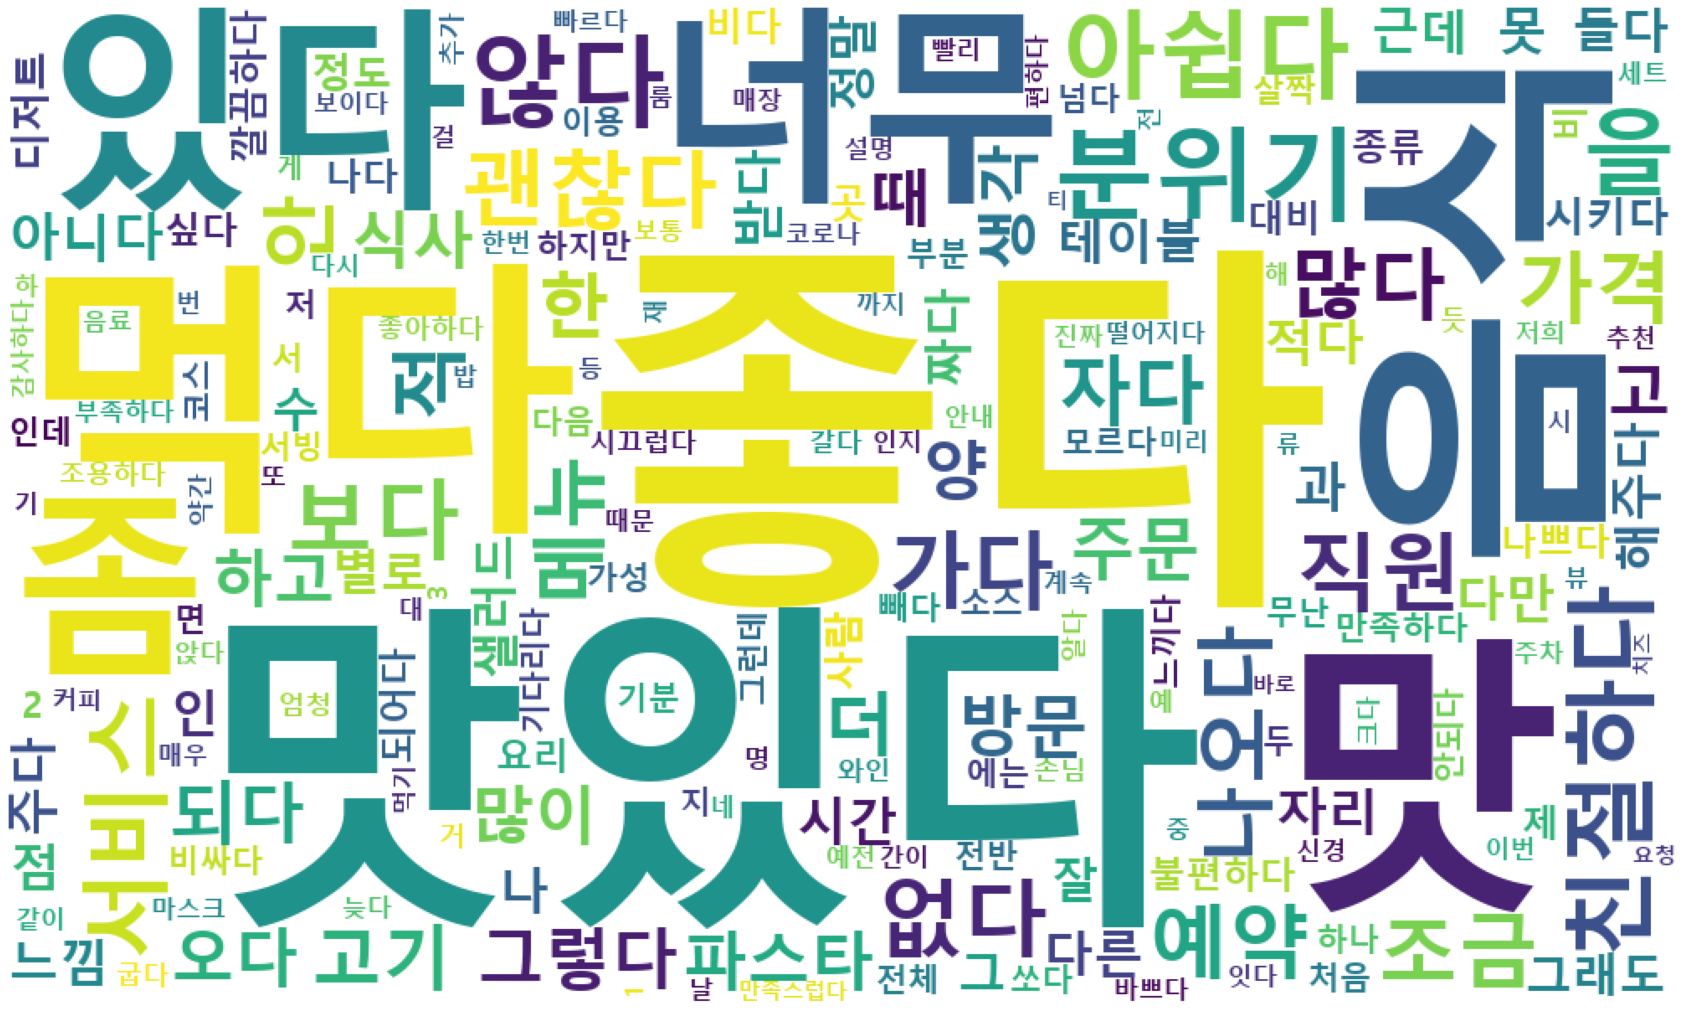

In [224]:
#유니그램으로 워드클라우드 확인
wc = WordCloud(width=1000, height=600, background_color="white", random_state=0, font_path='C:/Windows/Fonts/malgunbd.ttf')
plt.figure(figsize=(30,20))
plt.imshow(wc.generate_from_frequencies(vocab))
plt.axis("off")
plt.show()

- 유니그램만으로는 단어의 의미를 파악하기 어렵다
 - '맛', '먹다', '음식', '너무' 처럼 ngram으로 보아야 하는 단어들 존재


100%|██████████████████████████████████████████████████████████████████████████| 3595/3595 [00:00<00:00, 116277.54it/s]


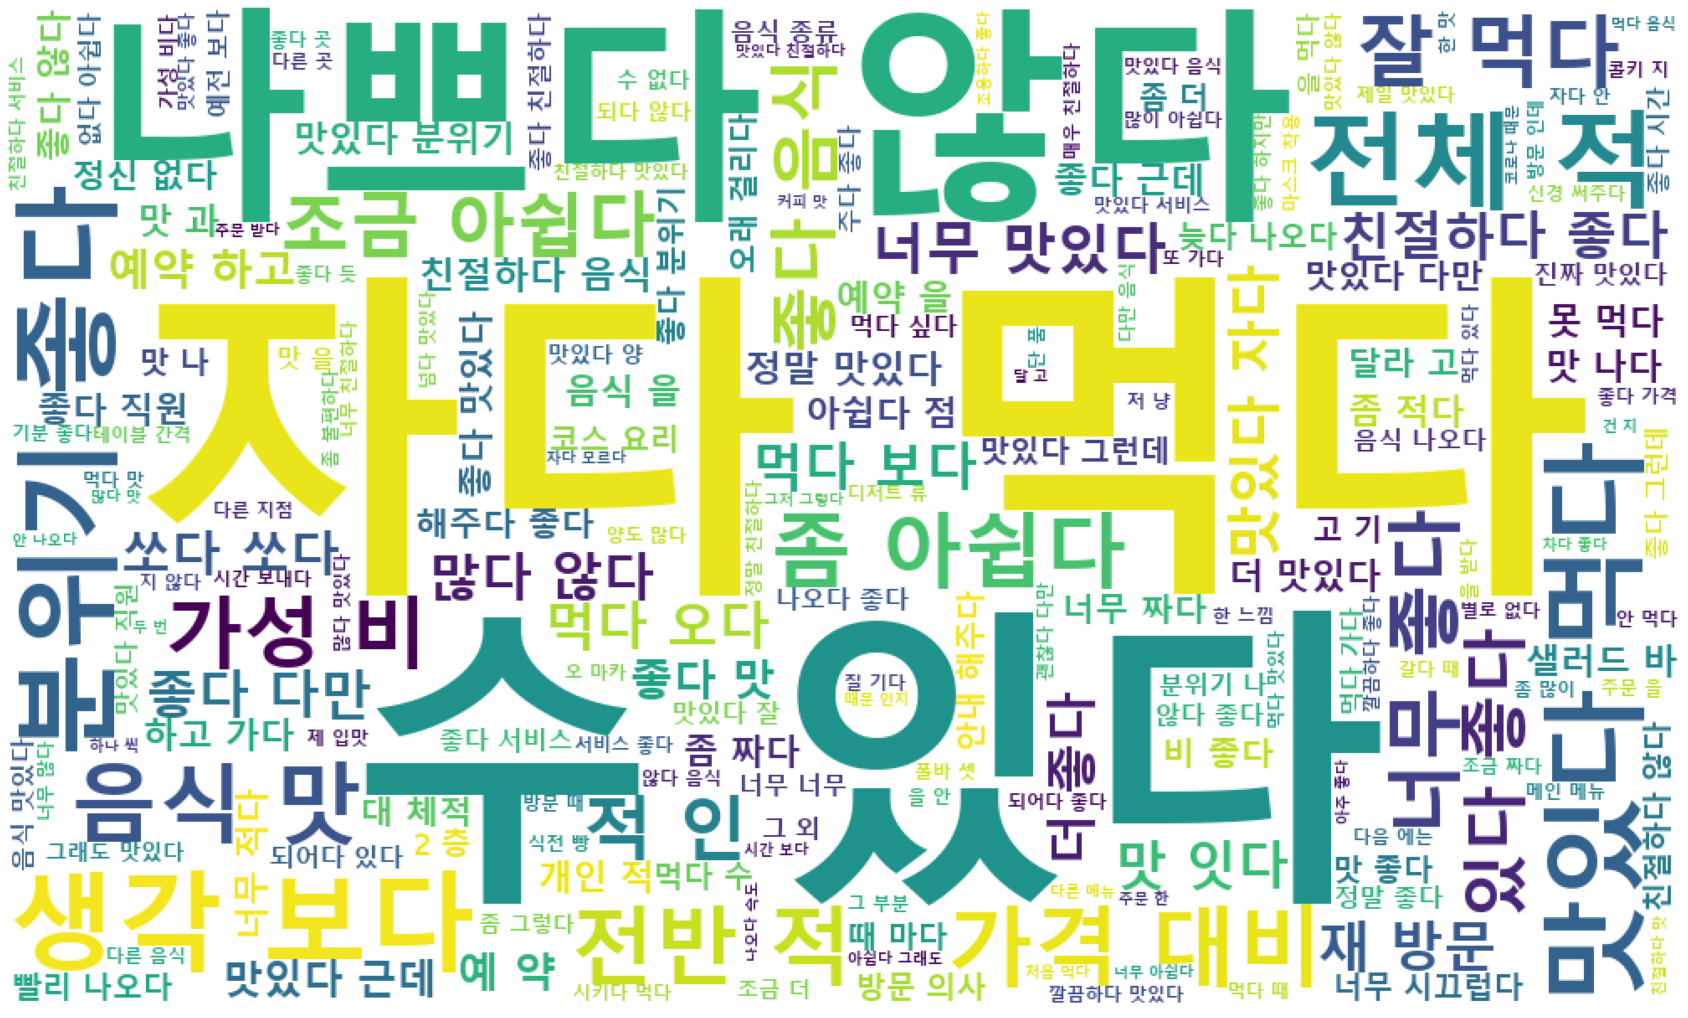

In [225]:
#바이그램으로 워드클라우드 확인
bigram_sentences = []
for review in tqdm(review_3_modi):
    bigram = ngrams(review, 2, pad_left=True, pad_right = True, left_pad_symbol='SS', right_pad_symbol='SE')
    bigram_sentences += [t for t in bigram if not t[0] in stopwords and not t[1] in stopwords and not 'SS' in bigram and not 'SE' in bigram]

bigram_list = []
for bigram in bigram_sentences:
    bi = (' ').join(bigram)
    bigram_list.append(bi)

vocab = FreqDist(np.hstack(bigrams))

wc = WordCloud(width=1000, height=600, background_color="white", random_state=0, font_path='C:/Windows/Fonts/malgunbd.ttf')
plt.figure(figsize=(30,20))
plt.imshow(wc.generate_from_frequencies(vocab))
plt.axis("off")
plt.show()

100%|███████████████████████████████████████████████████████████████████████████| 3595/3595 [00:00<00:00, 25742.47it/s]


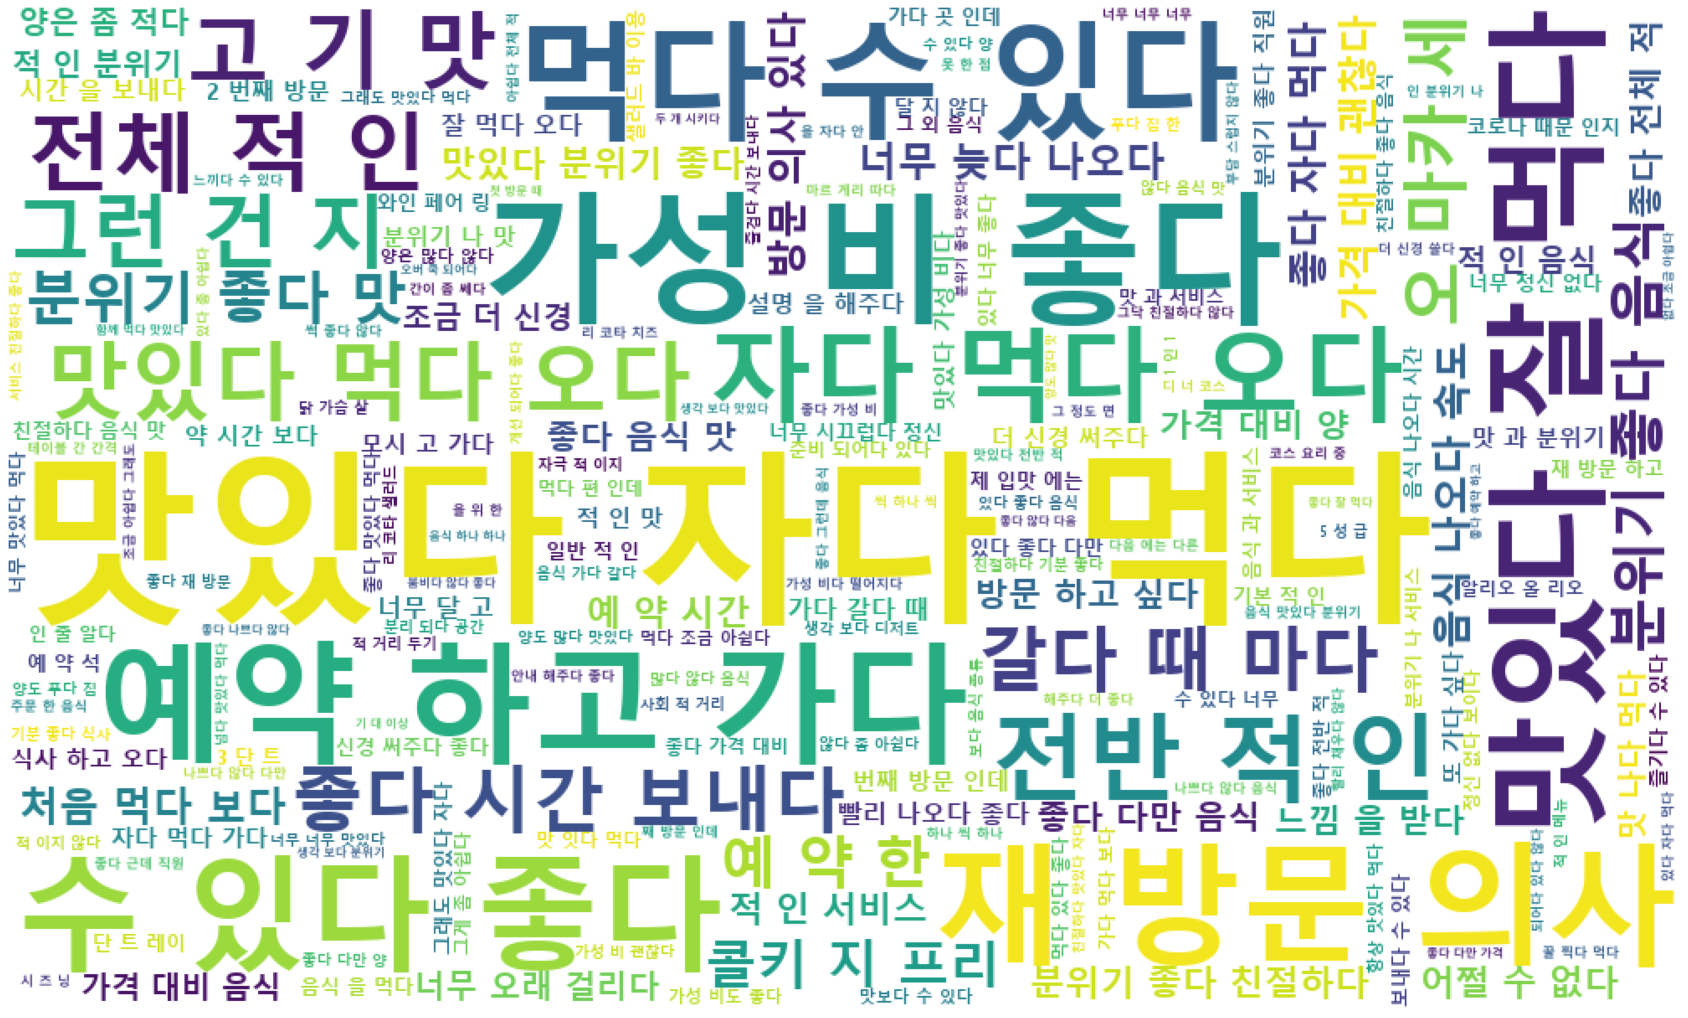

In [226]:
#바이그램으로 워드클라우드 확인
trigram_sentences = []
for review in tqdm(review_3_modi):
    trigram = ngrams(review, 3, pad_left=True, pad_right = True, left_pad_symbol='SS', right_pad_symbol='SE')
    trigram_sentences += [t for t in trigram if not t[0] in stopwords and not t[1] in stopwords and not t[2] in stopwords and not 'SS' in t and not 'SE' in t]      
    
trigram_list = []
for trigram in trigram_sentences:
    tri = (' ').join(trigram)
    trigram_list.append(tri)

vocab = FreqDist(np.hstack(trigram_list))

wc = WordCloud(width=1000, height=600, background_color="white", random_state=0, font_path='C:/Windows/Fonts/malgunbd.ttf')
plt.figure(figsize=(30,20))
plt.imshow(wc.generate_from_frequencies(vocab))
plt.axis("off")
plt.show()

- 긍정이 많지만 부정 또한 일정 비율로 보이는 것을 알 수 있다. 
- 4, 5점에 쏠려있는 편중 현상과 3.5점에서 보이는 일정 부분의 부정적인 리뷰를 바탕으로 3.5점을 긍정과 부정의 

# 감성사전 만들기

In [18]:
#4-5점에 포진된 데이터로 인해서 3.5 초과를 긍정, 그 아래를 부정으로 
df['라벨'] = df['평점'].apply(lambda x: 1 if x> 3.5 else 0)

In [21]:
# 긍정 리뷰 수와 부정 리뷰수 확인
len(df[df['라벨'] == 1]), len(df[df['라벨'] == 0])

(499780, 49343)

- 긍정 리뷰가 부정 리뷰에 비해 10배 가량 많다
- 양측의 비율을 균등하게 할 필요성이 있음

In [25]:
neg_df = df[df['라벨'] == 0]

#가게 순서대로 되어있기에, 순서를 섞지 않고 추출하면 특정 가게 리뷰에만 쏠릴 수 있음
df = shuffle(df)

pos_df = df[df['라벨'] == 1]

sent_df = pd.concat([neg_df, pos_df])

In [299]:
sent_df['리뷰전처리'] = sent_df['리뷰전처리'].apply(lambda x: (' ').join(x))

# 카테고리별 감성분석
- 서비스 / 맛 / 가격 / 분위기 
- 각 카테고리의 키값을 기준으로 n-gram 추출, 이후 해당 키 값 주변에 해당 value값이 존재하는지 확인
- https://soyoung-new-challenge.tistory.com/46 를 참고하여 감성분석 사전을 생성하였으며, key와 value 추가

In [301]:
service_good_feature = {'서비스':['좋','친절','괜찮','최고','빠르','짱','훌륭','추천','감사','구수',
                               '최상','대박','훈훈','특별','개이득','만족','세련','최고','감동', 
                               '만점', '꼼꼼', '만족', '기막히다', '상냥', '섬세', '뛰어나다' ],
                        '대응' : ['좋','친절','괜찮','최고','빠르','짱','훌륭','추천','감사','구수',
                               '최상','대박','훈훈','특별','개이득','만족','세련','최고','감동', 
                               '만점', '꼼꼼', '만족', '기막히다', '상냥', '섬세', '뛰어나다' ],
                        '응대' : ['좋','친절','괜찮','최고','빠르','짱','훌륭','추천','감사','구수',
                               '최상','대박','훈훈','특별','개이득','만족','세련','최고','감동', 
                               '만점', '꼼꼼', '만족', '기막히다', '상냥', '섬세', '뛰어나다' ],
                        
                        '사장': ['친절','스윗','센스', '감사', '고맙', '매너', '감동', '상냥', '섬세'],
                        '알바':['친절','스윗','센스', '감사', '고맙', '매너', '감동', '상냥', '섬세'],
                        '직원': ['친절','스윗','센스', '감사', '고맙', '매너', '감동', '상냥', '섬세'],
                        '매니저': ['친절','스윗','센스', '감사', '고맙', '매너', '감동', '상냥', '섬세'],
                        '종업원':['친절','스윗','센스', '감사', '고맙', '매너', '감동', '상냥', '섬세'],
                        '일을':['잘','빠르게',
                             '신속하게'],
                        '일도':['잘','빠르게',
                             '신속하게'],
                        '서빙':['잘','빠르게',
                             '신속하게'], 
                       }

service_bad_feature = {'서비스': ['아쉽','최악','나쁘','느리','빡치','비추','별로','그냥','낙제','쏘다쏘다','엉망','실망','불친절','문제','컴플레인',
                               '거지','그닥','그다지','구려','불편','엉성','헬','개판',
                              '않다','부족','형편','불만족'  ],
                       '대응' :['아쉽','최악','나쁘','느리','빡치','비추','별로','그냥','낙제','쏘다쏘다','엉망','실망','불친절','문제','컴플레인',
                               '거지','그닥','그다지','구려','불편','엉성','헬','개판',
                              '않다','부족','형편','불만족'  ],
                       '응대' :['아쉽','최악','나쁘','느리','빡치','비추','별로','그냥','낙제','쏘다쏘다','엉망','실망','불친절','문제','컴플레인',
                               '거지','그닥','그다지','구려','불편','엉성','헬','개판',
                              '않다','부족','형편','불만족'  ],
                       '알바':['불친절','똑바로','재수',
                            '짜증나다', '모자라다','서툴다','이상하다', '떠들다', '쓰레기'],
                       '사장':['불친절','똑바로','재수',
                            '짜증나다', '모자라다','서툴다','이상하다', '떠들다', '쓰레기'],
                       '직원':['불친절','똑바로','재수',
                            '짜증나다', '모자라다','서툴다','이상하다', '떠들다', '쓰레기'],
                       '매니저':['불친절','똑바로','재수',
                            '짜증나다', '모자라다','서툴다','이상하다', '떠들다', '쓰레기'],
                       '종업원':['불친절','똑바로','재수',
                            '짜증나다', '모자라다','서툴다','이상하다', '떠들다', '쓰레기'],
                      '일을':['못','느리게','천천히',
                            '답답','서툴다'],
                      '일도':['못','느리게','천천히',
                            '답답','서툴다'],
                      '서빙':['못','느리게','천천히',
                            '답답','서툴다']}

taste_good_feature = {'간':['맞','적절','딱','환상','담백'
                          '좋'],
                      '음식':['깔끔'
                           '대박', '건강', ],
                      '맛':['있','좋','나다','최고', '존', '쵝오'],
                      '잘':['먹'],
                     '질리': ['않', '안'],
                     '요리' : ['굳'],
                     '위생' :['적', '뛰어나다', '철저하다', '만족하다', '신경', '깔끔']}

taste_bad_feature = {'간':['세','쎄','강하다','별로'
                         '안', '짜', ],
                     '음식':['별로','쏘다쏘다','최악'
                          '차갑', '아쉽', '인스턴트'],
                     '맛':['별로','최악',
                         '뻔하다'],
                     '잘':[],
                     '질리':[],
                     '요리':[],
                    '위생':['아쉽다', '별로', '최악', '너무하다', '황당하다'],
                    }

taste_good_emotion = ['고소','부드럽','신선','촉촉','싱싱','정갈','최고', '굿']

taste_bad_emotion = ['싱겁','느끼하다','짜다','느끼다','짜다','딱딱하다','차갑다',
                    '질기다', '비리다' ]

cost_good_feature = {'가격': ['괜찮','착하다','저렴','적당','싸다','좋다','합리적','훌륭','최고','만족','마음','든든','알맞다',
                            '무난','괜춘','최상','굿','엄지','낮', '알차다'],
                     '가성비':['괜찮','착하다','저렴','적당','싸다','좋다','합리적','훌륭','최고','만족','마음','든든','알맞다',
                            '무난','괜춘','최상','굿','엄지',
                           '짱', '감탄', '알차다'],  
                     '양':['많','적당','푸짐','괜찮다','넉넉','충분','든든', 
                         '혜자'],
                     '배' : ['터지다']
                     }

cost_bad_feature ={'가격': ['비싸','있다','나쁘','사악','비효율','높다','부담','아쉽','쏘다쏘다','별로','그닥','그다지','쎄','ㅎㄷㄷ','높','거품'],
                   '가성비':['별로'],
                   '양':['적다','작다','아쉽','적다','다소','별로', 
                        '부족','적어지다'],
                   '배':['안']
                   }

atmosphere_good_feature = {'분위기': ['좋','괜찮','조용','깔끔','적당','깡패','굉장','아담','완벽','아기자기','고급','최고','세련','만족','아늑','훌륭','예쁘','이쁘','짱',
                                   '심쿵','따뜻','깨끗','독특','매력','모던','취향저격','맘','마음','클래식','아름','인상적','귀엽','포근',
                                  '완벽', '색다르다', '잔잔', '편안', '안락', '아기자기', '우아', ], 
                           '인테리어': ['좋','괜찮','조용','깔끔','적당','깡패','굉장','아담','완벽','아기자기','고급','최고','세련','만족','아늑','훌륭','예쁘','이쁘','짱',
                                    '심쿵','따뜻','깨끗','독특','매력','모던','취향저격','맘','마음','클래식','아름','인상적','귀엽','포근',
                                   '완벽', '색다르다', '잔잔', '편안', '안락', '아기자기', '우아',]}

atmosphere_bad_feature = {'분위기': ['나쁘다','바쁘다','어수선하다','이상하다','촌스럽다','별로','부담스럽다','시끄럽','복잡', 
                                 '산만하다', '실망','평범하다', ],
                          '인테리어':[]}

visit_good_feature = {'의사':['있다','충만','백프로','백프롭','많','만땅','마구','그득','만점','넘침'],
                      '다시':['가다','오다','방문','찾다','가보다','한번','갈다','찾아가다','가야지','갈거다','방문하다보고',
                            '생각나다','방문한다면','와보고','재방문','접하다','간다면','갈다때가','먹다고프다','방문한다임','오자고','가기로','갈다생각이다','가면'],
                      '굳이':[]}

visit_bad_feature = {'의사':['글쎄'],
                     '굳이':['다시','많이','여기까지','줄서서','찾아','시키다','가다','찾다','여기','기다리다','줄을','사먹'],
                     '다시':[]}

negative_word_emotion = ['안','않','못','없','아닌','아니']


In [302]:
def get_feature_keywords(feature_keywords, review):
    feature_temp = []
    for keyword in feature_keywords:
        if re.findall(keyword, review):
            sub_list = ['게','고','음','며','데','만','도','면']
            
            for sub in sub_list:
                if sub+' ' in review:
                    review = re.sub(sub+' ', sub+',', review)
                
            a = re.findall(keyword +'+[ㄱ-ㅎ|ㅏ-ㅣ|가-힣]+\s+[ㄱ-ㅎ|ㅏ-ㅣ|가-힣]+\s+[ㄱ-ㅎ|ㅏ-ㅣ|가-힣]+',review) # 키워드&한 한글 한글
            b = re.findall(keyword + '+\s+[ㄱ-ㅎ|ㅏ-ㅣ|가-힣]+\s+[ㄱ-ㅎ|ㅏ-ㅣ|가-힣]+',review) # 키워드 한글 한글 
            c = re.findall('[ㄱ-ㅎ|ㅏ-ㅣ|가-힣]+\s+' + keyword +'[ㄱ-ㅎ|ㅏ-ㅣ|가-힣]+',review) # 한글 키워드 한글
            d = re.findall('[ㄱ-ㅎ|ㅏ-ㅣ|가-힣]+\s+[ㄱ-ㅎ|ㅏ-ㅣ|가-힣]+\s' + keyword, review) #한글 한글 키워드
                
            for ngram in a:
                t = ()
                feature_temp.append(t + (ngram,keyword))
            for ngram in b:
                t = ()
                feature_temp.append(t + (ngram,keyword))
            for ngram in c:
                t = ()
                feature_temp.append(t + (ngram,keyword))
            for ngram in d:
                t = ()
                feature_temp.append(t + (ngram,keyword))

                
    return feature_temp

In [303]:
def get_feature_emotions(feature_good_dict,feature_bad_dict, feature_temp):
    good_feature_emotion_list = []
    bad_feature_emotion_list = []
    
    for ngrams in feature_temp:
        keyword = ngrams[1]
        ngram = ngrams[0]
        is_bad_feature = None
        
        good_emotion_list = feature_good_dict[keyword]
        bad_emotion_list = feature_bad_dict[keyword]
        for emotion in good_emotion_list:
            if re.findall(emotion, ngram):
                is_bad_feature = False  
        for emotion in bad_emotion_list:
            if re.findall(emotion, ngram):
                is_bad_feature = True    
        for negative in negative_word_emotion:
            if re.findall(negative, ngram):
                if is_bad_feature == True:
                    is_bad_feature = False
                    break
                elif is_bad_feature == False:
                    is_bad_feature = True
                    break
                else:
                    is_bad_feature = True
                    break   
        if is_bad_feature:
            bad_feature_emotion_list.append(ngram)
        elif is_bad_feature == False:
            good_feature_emotion_list.append(ngram)
        else:
            pass
    return good_feature_emotion_list, bad_feature_emotion_list

def get_taste_emotion(taste_good_emotions, taste_bad_emotions):
    bad_taste_emotion_list = []
    good_taste_emotion_list = []
    for ngrams in taste_good_emotions:
        ngram = ngrams[0]
        is_bad_taste = False
        for negative in negative_word_emotion:
            if re.findall(negative,ngram):
                is_bad_taste = True
        if is_bad_taste:
            bad_taste_emotion_list.append(ngram)
        else:
            good_taste_emotion_list.append(ngram)
    
    for ngrams in taste_bad_emotions:
        ngram = ngrams[0]
        is_bad_taste = True
        for negative in negative_word_emotion:
            if re.findall(negative,ngram):
                is_bad_taste = False
        if is_bad_taste:
            bad_taste_emotion_list.append(ngram)
        else:
            good_taste_emotion_list.append(ngram)
            
    return good_taste_emotion_list, bad_taste_emotion_list

In [586]:
check_division = lambda x, y: y if y ==0 else round((x / float(y)),2)
score_df = pd.DataFrame(columns = ['가게이름', '전체리뷰', '카테고리별 긍정/부정(서비스, 분위기, 가격, 맛)', '카테고리별 점수(서비스, 분위기, 가격, 맛)','재방문 긍정/부정', '재방문 점수', '평균평점'])

for restaurant in df['가게이름'].unique():
    temp_df = df[df['가게이름'] == restaurant]
    mean_score = np.round(temp_df['평점'].mean(),2)
    
    restaurant_good_service_count = 0
    restaurant_bad_service_count = 0
    restaurant_good_atmosphere_count =0
    restaurant_bad_atmosphere_count =0
    restaurant_good_cost_count =0
    restaurant_bad_cost_count =0
    restaurant_good_visit_count = 0
    restaurant_bad_visit_count = 0
    restaurant_good_taste_count = 0
    restaurant_bad_taste_count = 0

    for review in temp_df['리뷰전처리']:
        service_temp = get_feature_keywords(service_good_feature.keys(), review)
        good_service,bad_service = get_feature_emotions(service_good_feature, service_bad_feature, service_temp)

        atmosphere_temp = get_feature_keywords(atmosphere_good_feature.keys(), review)
        good_atmosphere,bad_atmosphere = get_feature_emotions(atmosphere_good_feature, atmosphere_bad_feature, atmosphere_temp)

        cost_temp = get_feature_keywords(cost_good_feature.keys(), review)
        good_cost,bad_cost = get_feature_emotions(cost_good_feature, cost_bad_feature, cost_temp)

        visit_temp = get_feature_keywords(visit_good_feature.keys(), review)
        good_visit,bad_visit = get_feature_emotions(visit_good_feature, visit_bad_feature, visit_temp)

        taste_temp = get_feature_keywords(taste_good_feature.keys(), review)
        good_taste,bad_taste = get_feature_emotions(taste_good_feature, taste_bad_feature, taste_temp)
        taste_good_emotion_temp = get_feature_keywords(taste_good_emotion, review)
        taste_bad_emotion_temp = get_feature_keywords(taste_bad_emotion, review)
        good_taste2, bad_taste2 = get_taste_emotion(taste_good_emotion_temp,taste_bad_emotion_temp)
        good_taste.extend(good_taste2)
        bad_taste.extend(bad_taste2)

        if len(good_service) > len(bad_service):
            restaurant_good_service_count += 1
        elif len(good_service) < len(bad_service):
            restaurant_bad_service_count += 1
        else:
            pass

        if len(good_atmosphere) > len(bad_atmosphere):
            restaurant_good_atmosphere_count += 1
        elif len(good_atmosphere) < len(bad_atmosphere):
            restaurant_bad_atmosphere_count += 1
        else:
            pass

        if len(good_cost) > len(bad_cost):
            restaurant_good_cost_count += 1
        elif len(good_cost) < len(bad_cost):
            restaurant_bad_cost_count += 1
        else:
            pass

        if len(good_visit) > len(bad_visit):
            restaurant_good_visit_count += 1
        elif len(good_visit) < len(bad_visit):
            restaurant_bad_visit_count += 1
        else:
            pass

        if len(good_taste) > len(bad_taste):
            restaurant_good_taste_count += 1
        elif len(good_taste) < len(bad_taste):
            restaurant_bad_taste_count += 1
        else:
            pass
    #전체 카운트
    TT = restaurant_good_service_count + restaurant_bad_service_count + restaurant_good_taste_count + restaurant_bad_taste_count + restaurant_good_atmosphere_count + restaurant_bad_atmosphere_count + restaurant_good_cost_count + restaurant_bad_cost_count
    
    if TT > 5: #threshold = 5 / 스코어의 기준이 되는 리뷰가 5개 이하면 버림
         restaurant_info = np.array([restaurant,len(temp_df),[(restaurant_good_service_count,restaurant_good_service_count + restaurant_bad_service_count),
                            (restaurant_good_atmosphere_count,restaurant_good_atmosphere_count + restaurant_bad_atmosphere_count),
                            (restaurant_good_cost_count,restaurant_good_cost_count + restaurant_bad_cost_count),
                            (restaurant_good_taste_count,restaurant_good_taste_count + restaurant_bad_taste_count)],
                            [100*check_division(restaurant_good_service_count, restaurant_good_service_count + restaurant_bad_service_count), 
                            100*check_division(restaurant_good_atmosphere_count,restaurant_good_atmosphere_count + restaurant_bad_atmosphere_count),
                            100*check_division(restaurant_good_cost_count,restaurant_good_cost_count + restaurant_bad_cost_count),
                            100*check_division(restaurant_good_taste_count,restaurant_good_taste_count + restaurant_bad_taste_count)],
                            (restaurant_good_visit_count,restaurant_good_visit_count + restaurant_bad_visit_count),
                            100*check_division(restaurant_good_visit_count,restaurant_good_visit_count + restaurant_bad_visit_count),
                            mean_score]) 
         restaurant_df = pd.DataFrame(restaurant_info.reshape(1,-1), columns = score_df.columns)
         score_df = pd.concat([restaurant_df, score_df])


In [591]:
score_df.sort_values('카테고리별 긍정/부정(서비스, 분위기, 가격, 맛)', ascending=False, inplace=True)

In [592]:
best_category = []
worst_category = []

for num, score in zip(score_df['카테고리별 긍정/부정(서비스, 분위기, 가격, 맛)'], score_df['카테고리별 점수(서비스, 분위기, 가격, 맛)']):
    category = ['서비스', '분위기', '가격', '맛']
    
    if score.count(0) >= 2:
        best_category.append('탐색불가')
        worst_category.append('탐색불가')
    else:
        max_score = max(score)
        max_index = []
        min_score = min(score)
        min_index = []

        #추천
        for i, cat in enumerate(score):
            if cat == max_score:
                max_index.append(i)
        
        #한 개 일 때
        if len(max_index) == 1:
            best_category.append(category[max_index[0]])
        #여러개 일 때 리뷰가 많은 것을 기준으로
        else:
            big_index, big_value = max(enumerate(num), key=operator.itemgetter(1)) #최대인 리뷰 index 추출
            best_category.append(category[big_index])
        
        #비추천
        for i, cat in enumerate(score):
            if cat == min_score:
                min_index.append(i)
        
        #한 개 일 때
        if len(min_index) == 1:
            worst_category.append(category[min_index[0]])
        #여러개 일 때 리뷰가 많은 것을 기준으로
        else:
            small_index, small_value = min(enumerate(num), key=operator.itemgetter(1)) #최소인 리뷰 index 추출
            worst_category.append(category[small_index])
            

In [593]:
score_df['추천'], score_df['비추천'] = best_category, worst_category

In [596]:
score_df[:20]

,가게이름,전체리뷰,"카테고리별 긍정/부정(서비스, 분위기, 가격, 맛)","카테고리별 점수(서비스, 분위기, 가격, 맛)",재방문 긍정/부정,재방문 점수,평균평점,추천,비추천
0,대,14781,"[(1734, 2083), (100, 128), (89, 152), (3399, 4...","[83.0, 78.0, 59.0, 84.0]","(37, 109)",34,4.5,맛,가격
0,롯데호텔서울 라세느,5153,"[(709, 763), (114, 131), (42, 162), (1902, 2090)]","[93.0, 87.0, 26.0, 91.0]","(18, 37)",49,4.6,서비스,가격
0,울프강 스테이크하우스,4021,"[(501, 587), (251, 282), (144, 229), (1432, 15...","[85.0, 89.0, 63.0, 91.0]","(27, 49)",55,4.49,맛,가격
0,하이디라오 홍대점,2299,"[(472, 537), (15, 19), (31, 71), (730, 801)]","[88.0, 79.0, 44.0, 91.0]","(12, 26)",46,4.64,맛,가격
0,하이디라오 서초지점,2400,"[(463, 514), (16, 18), (14, 70), (767, 834)]","[90.0, 89.0, 20.0, 92.0]","(12, 14)",86,4.63,맛,가격
0,아웃백스테이크하우스 강남점,3420,"[(450, 535), (78, 86), (20, 42), (847, 984)]","[84.0, 91.0, 48.0, 86.0]","(9, 27)",33,4.55,분위기,가격
0,탐라도야지,4531,"[(442, 504), (11, 13), (100, 140), (2386, 2498)]","[88.0, 85.0, 71.0, 96.0]","(16, 22)",73,4.84,맛,가격
0,하이디라오코리아(유),2010,"[(441, 488), (8, 10), (10, 56), (661, 752)]","[90.0, 80.0, 18.0, 88.0]","(8, 24)",33,4.58,서비스,가격
0,(유)아웃백스테이크하우스코리아,4025,"[(439, 563), (19, 28), (19, 42), (884, 1119)]","[78.0, 68.0, 45.0, 79.0]","(17, 54)",31,4.32,맛,가격
0,하이디라오 건대지점,1702,"[(417, 454), (13, 15), (22, 51), (547, 590)]","[92.0, 87.0, 43.0, 93.0]","(7, 11)",64,4.7,맛,가격
